# Notebook Transaksi Mesin Ramayana Makmur Sentosa Playzone Tahun 2024 - 2025

## Data Wrangling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # Kita pakai Plotly agar grafik interaktif (cocok buat Streamlit)
import re
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from rapidfuzz import fuzz

Load Data

In [ ]:
# Konfigurasi tampilan pandas
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# LOAD DATA
# Pastikan file ini adalah hasil output dari script terakhir Anda
file_path = "REKAP_DATA_MESIN_FULL.xlsx"
df = pd.read_excel(file_path)

print(f"Data Loaded: {df.shape[0]} baris, {df.shape[1]} kolom")
df.head()

Data Understanding : 
* Center = Nama toko
* Kode Game = Kode mesin individual
* Game Title = Nama mesin
* Keterangan = Nama mesin + jumlah player
* Kategori game = Jenis mesin
* Jumlah diaktifkan = Frekuensi mesin dimainkan per bulan
* Kredit yang digunakan = Jumlah uang yang dikeluarkan pemain pada suatu mesin per bulan
* Bonus yang digunakan = 
* Main Gratis/Koin Masuk = 
* QRIS = 
* Total = 
* Tiket/Koin Keluar = 
* Mercy Ticket = 
* Payout = 
* Avg. Ticket/Coin Out Per Play/Coin In = 
* Bulan = Periode bulan transaksi mesin
* Tahun = Periode tahun transaksi mesin
* Asal_Folder = Asal folder lokal data discraping
* Nama_File_Asal = Asal file lokal data discraping

Assesing Data

In [ ]:
df.info()

Dataframe df memiliki 147930 - 153452 entry data. Terdapat . Terdapat 5.522 data yang hilang. Untuk kolom tahun dan bulan masih berbentuk integer dan object sehingga perlu preprocessing menjadi datetime agar dapat difilter nantinya.

*Pemeriksaan parameter statistik*

In [ ]:
df.describe()

* Tidak ada outlier yang signifikan
* Kolom QRIS dan Mercy Ticket kosong sama sekali sehingga bisa didrop
* kolom Main Gratis/Koin Masuk,  Tiket/Koin Keluar, Payout, dan Avg. Ticket/Coin Out Per Play/Coin In banyak value yang kosong sehingga bisa didrop.

## Data Cleaning & Preprocessing

Drop kolom yang seluruhnya kosong dan mayoritas kosong karena sedikit informasinya. Serta asal folder dan file karena kurang informarif untuk analisis.

In [ ]:
cols_to_drop = [
    'QRIS', 
    'Mercy Ticket', 
    'Main Gratis/Koin Masuk', 
    'Tiket/Koin Keluar', 
    'Payout', 
    'Avg. Ticket/Coin Out Per Play/Coin In',
    'Asal_Folder',
    'Nama_File_Asal'

]
df.drop(columns=cols_to_drop, axis=1, inplace=True, errors='ignore')
display(df.head())

Pemeriksaan duplikasi

In [ ]:
print("Jumlah data duplikat dari df:", df.duplicated().sum())

Ada data duplikat, maka perlu dihandle.

In [ ]:
df_clean = df.drop_duplicates()

Cek kembali duplikat.

In [ ]:
print("Jumlah data duplikat dari df setelah dihandle:", df_clean.duplicated().sum())

Lihat null di setiap kolom

In [ ]:
# Menghitung jumlah null di setiap kolom
print(df.isna().sum())

Lihat presentase missing values

In [ ]:
# Menampilkan jumlah dan persentase
missing_data = df.isna().sum()
total_rows = len(df)

percent_missing = (missing_data / total_rows) * 100

# Gabungkan jadi satu tabel agar mudah dibaca
missing_df = pd.DataFrame({
    'Total Missing': missing_data,
    'Persentase (%)': percent_missing
})

# Tampilkan hanya kolom yang ada missing values-nya (urut dari terbesar)
print(missing_df[missing_df['Total Missing'] > 0].sort_values('Persentase (%)', ascending=False))

Cek baris yang kosong

In [ ]:
# Menampilkan baris yang memiliki setidaknya satu kolom kosong
baris_kosong = df[df.isna().any(axis=1)]

display(baris_kosong.head())

Drop missing value

In [ ]:
# Kolom yang ingin di drop
df.dropna(subset=['Center', 'Kode Game', 'Game Title'], inplace=True)

# Reset index agar urut kembali
df.reset_index(drop=True, inplace=True)

Cek kembali statistik umum setelah cleaning data

In [ ]:
df_clean.info()

Terdapat pengurangan banyaknya data menjadi 147931

**Cleaning data waktu agar datetime**

Mapping Bulan dan Tahun ke Tanggal (datetime) agar mudah dikategorikan

In [ ]:
# Standardisasi Nama Bulan ---
# Pastikan nama bulan konsisten (Title Case: Januari, bukan januari)
# Menggunakan df_clean
df_clean['Bulan'] = df_clean['Bulan'].astype(str).str.title()

# Mapping Bulan Indonesia ke Angka (Untuk bikin tanggal)
map_bulan = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
    'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
    'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}

df_clean['Bulan_Angka'] = df_clean['Bulan'].map(map_bulan)

# Membuat Kolom Tanggal (Date) ---
# Kita set tanggal 1 sebagai default karena data kita bulanan
# Menggunakan df_clean.Tahun dan df_clean.Bulan_Angka
df_clean['Tanggal'] = pd.to_datetime(dict(year=df_clean.Tahun, month=df_clean.Bulan_Angka, day=1))

# Filter Data Aneh (Optional) ---
# Contoh: Hapus jika Total_Sales negatif (jika perlu)
# df_clean = df_clean[df_clean['Total_Sales'] >= 0] 

print("Rentang Data:", df_clean['Tanggal'].min(), "sampai", df_clean['Tanggal'].max())
df_clean.info()

**Filter center yang aktif saja dan mapping standarisasi nama toko**

Map Toko Aktif

In [ ]:
# Key (Kiri) = Nama di Center
# Value (Kanan) = Nama Baru Standar
mapping_center = {
    # --- AREA R ---
    "Abepura (R-91)": "R091 Abepura",
    "Samarinda (R-94) RMS": "R094 Samarinda",
    "Panam (R-96)": "R096 Panam",
    "Kediri (R-98) RMS": "R098 Kediri",
    "Garut (R-99) RMS": "R099 Garut",
    "Sabar Subur": "R135 SS Tangerang",       
    "Cimone (R-26) IFS": "R026 Cimone",
    "Plaza Sukaramai Pekanbaru (R-56)": "R056 Pekanbaru",
    "Cirebon (R-100)": "R100 Cirebon",
    "Rajabasa Lampung": "R101 Rajabasa",
    "Kebayoran Lama (R-102) IFS": "R102 Kebayoran Lama",
    "Sorong (R-103)": "R103 Sorong",
    "Parung": "R105 Parung",
    "Cibadak (R-106)": "R106 Cibadak",
    "Pekalongan (R-110)": "R110 Pekalongan",
    "Yasmin Bogor": "R114 Bogor Yasmin",
    "Dinoyo": "R119 Dinoyo",
    "Tajur (R-121)": "R121 Tajur",
    "Cikupa": "R124 Cikupa",
    "Jatinegara": "R125 Jatinegara",
    "Timika (R-138)": "R138 Timika",
    "Dewi Sartika Bogor": "R015 Dewi Sartika",

    # --- AREA RB ---
    "Sukabumi (RB-05) RMS": "RB05 Sukabumi",
    "Cimahi (RB-12)": "RB12 Cimahi",
    "Gresik (RB-16) RMS": "RB16 Gresik",
    "Denpasar (RB-20) RMS": "RB20 Denpasar",
    "Sidoarjo (RB-27) RMS": "RB27 Sidoarjo",
    "Kudus (RB-28)": "RB28 Kudus",
    "Panbil Batam (RB-30) RMS": "RB30 Panbil",
    "Malang (RB-M) RMS": "RBM Malang",
    "Krian (RB-23)": "RB23 Krian",

    # --- AREA ZD ---
    "Ubud Bali": "ZD15 Bali Batu Bulan",
    "Wonosari": "ZD25 Wonosari",
    "Ponorogo (ZD-44)": "ZD44 Ponorogo",
    "Lotte Bintaro (ZD-46)": "ZD46 Lotte Bintaro",
    "Payakumbuh": "ZD39 Payakumbuh",
    "Mesra Samarinda (ZD-37)": "ZD37 Samarinda"
}

Filter dan Rename

In [ ]:
# Bersihkan spasi berlebih agar pencocokan akurat
df['Center'] = df['Center'].astype(str).str.strip()

# Langkah A: Filter (Hanya ambil data yang Center-nya ada di daftar mapping)
df_clean = df[df['Center'].isin(mapping_center.keys())].copy()

# Langkah B: Rename (Ubah nama lama jadi nama baru)
df_clean['Center'] = df_clean['Center'].map(mapping_center)

# ================= 3. CEK HASIL =================
print(f"Data Awal: {len(df)} baris")
print(f"Data Setelah Filter Center Aktif: {len(df_clean)} baris")
print("\nDaftar Center Aktif (Standardized):")
print(df_clean['Center'].unique())

# Update ke dataframe utama
df = df_clean

Coba Mapping 'Game Title'

In [ ]:
import re

def normalize_game_title(text: str) -> str:
    if not isinstance(text, str):
        return text

    text = text.upper()
    text = re.sub(r"\s+", " ", text)      # multiple space → single
    text = text.strip()
    return text


In [ ]:
def pre_clean(text):
    text = normalize_game_title(text)
    text = re.sub(r"\s?#\d+|\s?\([A-Z]\)", "", text)
    text = re.sub(r"\b(SD|TWIN|SINGLE|DELUXE|DX|JR|MINI|BIG)\b", "", text)
    return text.strip()


In [ ]:
game_title_map = {
    # ================= AIR HOCKEY =================
    "JUMBO AIR HOCKEY 2000": "JUMBO AIR HOCKEY",
    "PAIR MATCH HOCKEY": "JUMBO AIR HOCKEY",

    # ================= RAINBOW =================
    "RAINBOW SPINNER": "RAINBOW SPINNER",
    "RAINBOW SPINER": "RAINBOW SPINNER",
    "RANBOW SPINNER": "RAINBOW SPINNER",
    "RAINBOW SPINER": "RAINBOW SPINNER",
    "RAINBOW": "RAINBOW",

    # ================= SPEED DRIVER =================
    "SPEED DRIVER": "SPEED DRIVER",
    "SPEED DRIVER 3 SD TWIN": "SPEED DRIVER",
    "CRAZY SPEED": "SPEED DRIVER",
    "CRAZY SPEED SD SINGLE": "SPEED DRIVER",
    "CRAZY SPEED TWIN": "SPEED DRIVER",

    # ================= SPEED RIDER =================
    "SPEED RIDER": "SPEED RIDER",
    "SPEED RIDER 2 TWIN": "SPEED RIDER",
    "SPEED RIDER 3": "SPEED RIDER",
    "SPEED RIDER 3D": "SPEED RIDER",

    # ================= SPEEDING UP =================
    "SPEEDING UP": "SPEEDING UP",

    # ================= MAXIMUM TUNE =================
    "MAXIMUM TUNE": "MAXIMUM TUNE",

    # ================= RACING TUNED =================
    "RACING TUNED": "RACING TUNED",
    "R TUNED": "RACING TUNED",
    "R-TUNED RACING": "RACING TUNED",

    # ================= KERETA =================
    "KERETA KENCANA": "CLASSIC WAGOON",
    "KERETA GOYANG": "CLASSIC WAGOON",
    "KERETA WAHANA": "CHOOCHOO TRAIN",

    # ================= ZAMPERLA =================
    "ZAMPERLA HORSE": "ZAMPERLA RIDE",
    "ZAMPERLA UNTA": "ZAMPERLA RIDE",

    # ================= POP IT WIN =================
    "POP IT WIN": "POP IT WIN",
    "POP IT & WIN": "POP IT WIN",
    "POP IT N WIN": "POP IT WIN",
    "POT IT WIN": "POP IT WIN",
    "PO IT WIN": "POP IT WIN",
}


In [ ]:
df["Game Title Clean"] = (
    df["Game Title"]
    .apply(normalize_game_title)
    .replace(game_title_map)
)


In [ ]:
df.groupby("Game Title Clean")["Game Title"].nunique() \
  .sort_values(ascending=False) \
  .head(20)


In [ ]:
conflict = (
    df.assign(
        GT_NORM=df["Game Title"].apply(normalize_game_title),
        GT_CLEAN=lambda x: x["GT_NORM"].replace(game_title_map)
    )
    .groupby("GT_CLEAN")["GT_NORM"]
    .nunique()
    .reset_index(name="jumlah_variasi")
    .query("jumlah_variasi > 1")
    .sort_values("jumlah_variasi", ascending=False)
)

conflict


In [ ]:
detail = (
    df.assign(
        GT_NORM=df["Game Title"].apply(normalize_game_title),
        GT_CLEAN=lambda x: x["GT_NORM"].replace(game_title_map)
    )
    .query("GT_CLEAN in @conflict.GT_CLEAN")
    [["Game Title", "GT_NORM", "GT_CLEAN"]]
    .sort_values("GT_CLEAN")
)

detail


In [ ]:
def master_clean(text):
    text = normalize_game_title(text)

    text = re.sub(r"\s?#\d+|\s?\([A-Z]\)", "", text)

    if re.search(r"POP\s*I?T?\s*(N|&)?\s*WIN", text):
        return "POP IT WIN"

    if "CRAZY SPEED" in text or "SPEED DRIVER" in text:
        return "SPEED DRIVER"

    if "AIR HOCKEY" in text or "PAIR MATCH HOCKEY" in text:
        return "JUMBO AIR HOCKEY"

    if text in ["KERETA GOYANG", "KERETA KENCANA", "CLASSIC WAGON", "CLASSIC WAGOON"]:
        return "CLASSIC WAGOON"

    if re.search(r"R.?AINBOW\s*SPIN", text):
        return "RAINBOW SPINNER"

    if re.search(r"\bR\s*-?\s*TUNED\b", text) or "RACING TUNED" in text:
        return "RACING TUNED"

    if text in ["CHOOCHOO TRAIN", "KERETA WAHANA"]:
        return "CHOOCHOO TRAIN"

    if text.startswith("ZAMPERLA"):
        return "ZAMPERLA RIDE"

    return text


In [ ]:
df["GT_FINAL"] = df["Game Title"].apply(master_clean)

df.groupby("GT_FINAL")["GT_FINAL"].nunique().sort_values(ascending=False)


Dapatkan unique value untuk GT_FINAL

In [ ]:
titles = sorted(df["GT_FINAL"].unique())

Fuzzy Similarity

In [ ]:
rows = []

for i, a in enumerate(titles):
    for b in titles[i+1:]:
        score = fuzz.token_sort_ratio(a, b) / 100
        if score >= 0.85:   # threshold audit
            rows.append({
                "GT_A": a,
                "GT_B": b,
                "similarity": round(score, 2)
            })

audit_df = pd.DataFrame(rows).sort_values("similarity", ascending=False)
audit_df


Ekspor Audit Excel

In [ ]:
'''
output_path = "audit_game_title_similarity.xlsx"

audit_df.to_excel(
    output_path,
    index=False,
    sheet_name="Audit Similarity"
)

print(f"Audit berhasil diekspor ke {output_path}")
'''

Baca Audit Merge Excel ke Dataframe

In [ ]:
audit_df = pd.read_excel("audit_merge_map.xlsx")

audit_merge_map = dict(
    zip(
        audit_df["GT_B"].str.upper().str.strip(),
        audit_df["GT_A"].str.upper().str.strip()
    )
)


APPLY ke GT_FINAL

In [ ]:
df["GT_FINAL"] = (
    df["GT_FINAL"]
    .str.upper()
    .str.strip()
    .replace(audit_merge_map)
)


Validasi WAJIB

In [ ]:
set(audit_merge_map.keys()) & set(df["GT_FINAL"].unique())


Semua GT_A harus ADA

In [ ]:
set(audit_merge_map.values()) - set(df["GT_FINAL"].unique())


In [ ]:
df.groupby("GT_FINAL")["Game Title"].nunique() \
  .sort_values(ascending=False) \
  .head(20)


DEFINISI NORMALIZER (FINAL)

In [ ]:
def normalize_game_title(x: str) -> str:
    if pd.isna(x):
        return x
    x = x.upper()
    x = re.sub(r"[^\w\s]", " ", x)
    x = re.sub(r"\s+", " ", x)
    return x.strip()


LOAD & BUILD AUDIT MERGE MAP (FINAL)

In [ ]:
audit_df = pd.read_excel("audit_merge_map.xlsx")

audit_merge_map = dict(
    zip(
        audit_df["GT_B"].apply(normalize_game_title),
        audit_df["GT_A"].apply(normalize_game_title)
    )
)


APPLY KE DATA (FINAL APPLY)

In [ ]:
df["GT_FINAL"] = df["GT_FINAL"].apply(normalize_game_title)
df["GT_FINAL"] = df["GT_FINAL"].replace(audit_merge_map)


VALIDASI WAJIB

In [ ]:
remaining = set(audit_merge_map.keys()) & set(df["GT_FINAL"].unique())
remaining


MANUAL MAPPING

In [ ]:
manual_fix_map = {
    "E TICKET": "E-TICKET",
    "MAXIMUM TUNE 3": "MAXIMUM TUNE",
    "MAXIMUM TUNE 3 DX": "MAXIMUM TUNE",
    "TROLEY": "TROLLEY"
}


Apply manual fix

In [ ]:
df["GT_FINAL"] = df["GT_FINAL"].replace(manual_fix_map)


VALIDASI FINAL (HARUS KOSONG)

In [ ]:
{
    'E TICKET',
    'MAXIMUM TUNE 3',
    'MAXIMUM TUNE 3 DX',
    'TROLEY'
} & set(df["GT_FINAL"].unique())


In [ ]:
remaining = set(final_merge_map.keys()) & set(df["GT_FINAL"].unique())
remaining


APAKAH STRING-NYA BENAR-BENAR IDENTIK?

In [ ]:
for x in remaining:
    print(repr(x))


EKSPOR DF HASIL NORMALISASI

In [ ]:
print("Kolom df:")
print(df.columns.tolist())

print("\nKolom df_clean:")
print(df_clean.columns.tolist())


In [ ]:
(df['GT_FINAL'] == df_clean['GT_FINAL']).value_counts()


In [ ]:
df_clean['GT_FINAL'].value_counts().sum()

BUAT TANGGAL

In [ ]:
# Pastikan Bulan sudah title-case
df_clean['Bulan'] = df_clean['Bulan'].astype(str).str.title()

map_bulan = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
    'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
    'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}

df_clean['Bulan_Angka'] = df_clean['Bulan'].map(map_bulan)

# Buat kolom Tanggal (tanggal 1 tiap bulan)
df_clean['Tanggal'] = pd.to_datetime(
    dict(
        year=df_clean['Tahun'],
        month=df_clean['Bulan_Angka'],
        day=1
    )
)

# Validasi
print("Kolom sekarang:")
print(df_clean.columns.tolist())

print("Range tanggal:")
print(df_clean['Tanggal'].min(), "→", df_clean['Tanggal'].max())


LANGKAH FINAL YANG WAJIB DIKUNCI (BIAR STABIL)

In [ ]:
df_clean = df.copy()


EKSPOR DATA MESIN

In [ ]:
cols_export = [
    'Center',
    'GT_FINAL',
    'Kode Game',
    'Keterangan',
    'Kategori Game',
    'Jumlah Diaktifkan',
    'Kredit yg Digunakan',
    'Tanggal'
]

df_clean[cols_export].to_excel(
    "CLEAN_DATA_MESIN_FINAL.xlsx",
    index=False
)


EDA

In [ ]:
# Konfigurasi tampilan pandas
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# LOAD DATA
# Pastikan file ini adalah hasil output dari script terakhir Anda
file_path = "CLEAN_DATA_MESIN_FINAL.xlsx"
df_mesin = pd.read_excel(file_path)

print(f"Data Loaded: {df_mesin.shape[0]} baris, {df_mesin.shape[1]} kolom")
df_mesin.head()

In [ ]:
exclusions = [
    'KIDDIE LAND', 
    'KIDDIE LAND 1 JAM', 
    'KIDDIELAND MINI', 
    'KIDDIELAND SEPUASNYA',
    'KIDDIE ZONE 1 JAM'
]

# Pastikan string rapi
df_mesin['Kategori Game'] = df_mesin['Kategori Game'].astype(str).str.strip().str.upper()

# Filter exclude
df_mesin_excl = df_mesin[
    ~df_mesin['Kategori Game'].isin(exclusions)
].copy()

print("Sebelum exclude:", len(df_mesin))
print("Sesudah exclude :", len(df_mesin_excl))


In [ ]:


mesin_trend = (
    df_mesin_excl
    .groupby(pd.Grouper(key='Tanggal', freq='M'))
    [['Jumlah Diaktifkan', 'Kredit yg Digunakan']]
    .sum()
)

fig, ax1 = plt.subplots(figsize=(10,4))

# ===== Axis Kiri: Jumlah Diaktifkan =====
ax1.plot(
    mesin_trend.index,
    mesin_trend['Jumlah Diaktifkan'],
    marker='o',
    label='Jumlah Diaktifkan'
)
ax1.set_ylabel("Jumlah Diaktifkan")
ax1.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", "."))
)

# ===== Axis Kanan: Kredit yg Digunakan (Rupiah) =====
ax2 = ax1.twinx()
ax2.plot(
    mesin_trend.index,
    mesin_trend['Kredit yg Digunakan'],
    marker='s',
    linestyle='--',
    label='Kredit Digunakan (Rp)'
)
ax2.set_ylabel("Kredit Digunakan (Rp)")
ax2.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"Rp {x:,.0f}".replace(",", "."))
)

# ===== Judul & Legend =====
fig.suptitle("Tren Aktivitas Mesin", fontsize=12)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='upper left'
)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Pastikan kolom tanggal datetime
df_mesin_excl['Tanggal'] = pd.to_datetime(df_mesin_excl['Tanggal'])

# Tambah kolom Tahun
df_mesin_excl['Tahun'] = df_mesin_excl['Tanggal'].dt.year

# Filter hanya 2024 & 2025
df_comp = df_mesin_excl[df_mesin_excl['Tahun'].isin([2024, 2025])]

# Agregasi omset per tahun
omset_tahun = (
    df_comp
    .groupby('Tahun')['Kredit yg Digunakan']
    .sum()
    .reset_index()
)


In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax.bar(
    omset_tahun['Tahun'].astype(str),
    omset_tahun['Kredit yg Digunakan']
)

# Format Rupiah Indonesia di Y-axis
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"Rp {x:,.0f}".replace(",", "."))
)

ax.set_title("Komparasi Omset Mesin 2024 vs 2025")
ax.set_xlabel("Tahun")
ax.set_ylabel("Total Omset Mesin")

# Label di atas bar
for idx, row in omset_tahun.iterrows():
    ax.text(
        idx,
        row['Kredit yg Digunakan'],
        f"Rp {row['Kredit yg Digunakan']:,.0f}".replace(",", "."),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


Terjadi kesalahan di value, coba reset workflow.

# =========================================
# NOTEBOOK RESET – MESIN DASHBOARD
# Last reset: Jan 2026
# Semua cell di bawah harus dijalankan berurutan
# =========================================


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # Kita pakai Plotly agar grafik interaktif (cocok buat Streamlit)
import re
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from rapidfuzz import fuzz
from difflib import get_close_matches

In [2]:
df = pd.read_excel("REKAP_DATA_MESIN_FULL.xlsx")

print(df.columns)


Index(['Center', 'Kode Game', 'Game Title', 'Keterangan', 'Kategori Game',
       'Jumlah Diaktifkan', 'Kredit yg Digunakan', 'Bonus yg Digunakan',
       'Main Gratis/Koin Masuk', 'QRIS', 'Total', 'Tiket/Koin Keluar',
       'Mercy Ticket', 'Payout', 'Avg. Ticket/Coin Out Per Play/Coin In',
       'Bulan', 'Tahun', 'Asal_Folder', 'Nama_File_Asal'],
      dtype='object')


In [3]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153448 entries, 0 to 153447
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Center                                 153448 non-null  object 
 1   Kode Game                              153448 non-null  object 
 2   Game Title                             153448 non-null  object 
 3   Keterangan                             153448 non-null  object 
 4   Kategori Game                          153448 non-null  object 
 5   Jumlah Diaktifkan                      153448 non-null  int64  
 6   Kredit yg Digunakan                    153448 non-null  float64
 7   Bonus yg Digunakan                     153448 non-null  float64
 8   Main Gratis/Koin Masuk                 153448 non-null  object 
 9   QRIS                                   153448 non-null  int64  
 10  Total                                  153448 non-null  

Center                                   0
Kode Game                                0
Game Title                               0
Keterangan                               0
Kategori Game                            0
Jumlah Diaktifkan                        0
Kredit yg Digunakan                      0
Bonus yg Digunakan                       0
Main Gratis/Koin Masuk                   0
QRIS                                     0
Total                                    0
Tiket/Koin Keluar                        0
Mercy Ticket                             0
Payout                                   0
Avg. Ticket/Coin Out Per Play/Coin In    0
Bulan                                    0
Tahun                                    0
Asal_Folder                              0
Nama_File_Asal                           0
dtype: int64

tidak ada angka kredit yang “nggandain” lagi.

In [4]:
df[['Jumlah Diaktifkan', 'Kredit yg Digunakan']].describe()


,Jumlah Diaktifkan,Kredit yg Digunakan
count,153448.000000,1.534480e+05
mean,274.550962,1.275415e+06
std,410.786358,3.226525e+06
min,1.000000,0.000000e+00
25%,57.000000,1.764000e+05
50%,146.000000,5.194000e+05
75%,325.000000,1.338225e+06
max,10491.000000,3.237498e+08


cek cepat logika

In [5]:
print("Max Jumlah:", df['Jumlah Diaktifkan'].max())
print("Max Kredit:", df['Kredit yg Digunakan'].max())


Max Jumlah: 10491
Max Kredit: 323749776.0


Buat kolom tanggal datetime

In [6]:
bulan_map = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
    'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
    'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}

df['Bulan_num'] = df['Bulan'].map(bulan_map)

df['Tanggal'] = pd.to_datetime(
    dict(year=df['Tahun'].astype(int), month=df['Bulan_num'], day=1)
)


Standarisasi Game Title

In [7]:
df['Game Title'] = (
    df['Game Title']
    .astype(str)
    .str.strip()
    .str.upper()
)


Normalizer

In [8]:
def normalize_gt(s):
    if pd.isna(s):
        return s
    return (
        str(s)
        .upper()
        .strip()
        .replace('-', ' ')
        .replace('_', ' ')
    )


Aplikasi normalisasi

In [9]:
df['GT_RAW_NORM'] = df['Game Title'].apply(normalize_gt)


LOAD MAPPING & APPLY (INTI PERBAIKAN)

In [10]:
map_gt = pd.read_excel("mapping_gt.xlsx")

map_gt['GT_RAW_NORM'] = map_gt['GT_RAW'].apply(normalize_gt)

gt_dict = dict(
    zip(map_gt['GT_RAW_NORM'], map_gt['GT_FINAL'])
)

Apply mapping:

In [11]:
df['GT_FINAL'] = df['GT_RAW_NORM'].map(gt_dict)
df['GT_FINAL'] = df['GT_FINAL'].fillna(df['GT_RAW_NORM'])


AUDIT YANG SEHARUSNYA

In [12]:
audit_gt = (
    df.groupby('GT_FINAL')['GT_RAW_NORM']
    .nunique()
    .reset_index(name='jumlah_variasi')
    .sort_values('jumlah_variasi', ascending=False)
)


Lihat yang perlu merge lagi:

In [13]:
audit_gt[audit_gt['jumlah_variasi'] > 1]


,GT_FINAL,jumlah_variasi
4,AIR HOCKEY,18
532,KIDDIE LAND,11
622,MAXIMUM TUNE,9
1110,ZOOMOVE,8
433,HAPPY FROG,8
...,...,...
184,COMIC TRAIN,2
120,CAR SCHOOL,2
158,CHILDREN F1,2
182,COLORFUL BALL,2


KLASIFIKASI 127 VARIASI

In [14]:
audit_detail = (
    df[['GT_RAW_NORM', 'GT_FINAL']]
    .drop_duplicates()
    .sort_values('GT_FINAL')
)


Export untuk review:

In [15]:
'''
audit_detail.to_excel("AUDIT_GT_VARIASI.xlsx", index=False)
'''

'\naudit_detail.to_excel("AUDIT_GT_VARIASI.xlsx", index=False)\n'

Kebanyakan karena belum filter toko aktif

In [16]:
DICT_TOKO_NTA = {

    # ================== AREA R ==================
    "Ciputat (R-20)": "R020 Ciputat",
    "Bekasi (R-21)": "R021 Bekasi",
    "Pasar Minggu (R-22)": "R022 Pasar Minggu",
    "Tanjung Priok": "R029 Tanjung Priuk",
    "Tangerang (R-31) RMS": "R031 Tangerang",
    "Depok (R-34) RMS": "R034 Depok",
    "Cilegon (R-35) RMS": "R035 Cilegon",
    "Cibitung (R-37) RMS": "R037 Cibitung",
    "Klender (R-38) RMS": "R038 Klender 1",
    "Cengkareng (R-40)": "R040 Cengkareng",
    "Pematang Siantar (R-41) RMS": "R041 Siantar",
    "Jambi (R-45) RMS": "R045 Jambi",
    "Tanjung Karang Lampung": "R048 Lampung",
    "Ciledug (R-49) RMS": "R049 Ciledug",
    "Balikpapan (R-51)": "R051 Balikpapan",
    "Pangkal Pinang (R-52) RMS": "R052 Pangkal Pinang",
    "Pontianak (R-57)": "R057 Pontianak",
    "Medan (R-58) RMS": "R058 Medan 2",
    "Tarakan (R-60)": "R060 Tarakan",
    "Kupang (R-61) RMS": "R061 Kupang",
    "Banjarmasin": "R063 Banjarmasin",
    "Padang (R-66) RMS": "R066 Padang",
    "Mega Mal Karawang (R-67) RMS": "R067 Karawang",
    "Makasar 2 (R-70)": "R070 Makassar 2",
    "Bogor Trade Mall (R-71) RMS": "R071 BTM",
    "Serang (R-75) RMS": "R075 Serang",
    "Bukittinggi (R-77) RMS": "R077 Bukittinggi",
    "Makasar 3 (R-79) RMS": "R079 Makassar 3",
    "Dumai (R-80)": "R080 Dumai",
    "Bontang (R-81)": "R081 Bontang",
    "Banyuwangi": "R083 Banyuwangi",
    "Kerinci (R-86)": "R086 Kerinci",
    "Tebing Tinggi (R-89) RMS": "R089 Tebing Tinggi",
    "Abepura (R-91)": "R091 Abepura",
    "Samarinda (R-94) RMS": "R094 Samarinda",
    "Panam (R-96)": "R096 Panam",
    "Kediri (R-98) RMS": "R098 Kediri",
    "Garut (R-99) RMS": "R099 Garut",
    "Sabar Subur": "R135 SS Tangerang",

    # ================== AREA RB ==================
    "Sukabumi (RB-05) RMS": "RB05 Sukabumi",
    "Cimahi (RB-12)": "RB12 Cimahi",
    "Gresik (RB-16) RMS": "RB16 Gresik",
    "Denpasar (RB-20) RMS": "RB20 Denpasar",
    "Sidoarjo (RB-27) RMS": "RB27 Sidoarjo",
    "Kudus (RB-28)": "RB28 Kudus",
    "Panbil Batam (RB-30) RMS": "RB30 Panbil",
    "Malang (RB-M) RMS": "RBM Malang",
    "Krian (RB-23)": "RB23 Krian",

    # ================== AREA ZD ==================
    "Ubud Bali": "ZD15 Bali Batu Bulan",
    "Wonosari": "ZD25 Wonosari",
    "Ponorogo (ZD-44)": "ZD44 Ponorogo",
    "Lotte Bintaro (ZD-46)": "ZD46 Lotte Bintaro",
    "Payakumbuh": "ZD39 Payakumbuh",
    "Mesra Samarinda (ZD-37)": "ZD37 Samarinda",

    # ================== TAMBAHAN R ==================
    "Dewi Sartika Bogor": "R015 Dewi Sartika",
    "Cimone (R-26) IFS": "R026 Cimone",
    "Plaza Sukaramai Pekanbaru (R-56)": "R056 Pekanbaru",
    "Cirebon (R-100)": "R100 Cirebon",
    "Rajabasa Lampung": "R101 Rajabasa",
    "Kebayoran Lama (R-102) IFS": "R102 Kebayoran Lama",
    "Sorong (R-103)": "R103 Sorong",
    "Parung": "R105 Parung",
    "Cibadak (R-106)": "R106 Cibadak",
    "Pekalongan (R-110)": "R110 Pekalongan",
    "Yasmin Bogor": "R114 Bogor Yasmin",
    "Dinoyo": "R119 Dinoyo",
    "Tajur (R-121)": "R121 Tajur",
    "Cikupa": "R124 Cikupa",
    "Jatinegara": "R125 Jatinegara",
    "Timika (R-138)": "R138 Timika",
}


STEP VALIDASI

In [17]:
df['Center_NORM'] = df['Center'].str.upper().str.strip()

unmapped = set(df['Center_NORM']) - set(k.upper() for k in DICT_TOKO_NTA.keys())
print("UNMAPPED CENTER:")
unmapped


UNMAPPED CENTER:


{'AMBOJA (ZD-45)',
 'BATAM (RB-21)',
 'BATURAJA',
 'BLOK M SQUARE',
 'BUNGURASIH',
 'CIANJUR (R-46) RMS',
 'CIBINONG 1 (R-43)',
 'CIBINONG 2 (R-107)',
 'CIPANAS (R-137) IFS',
 'CIPANAS (R-137) RMS',
 'CLANDYS SEMARANG (ZD-48) IFS',
 'DURI (R-85)',
 'GARUT (R-99) IFS',
 'GRESIK (RB-16) IFS',
 'KEDIRI (R-98) IFS',
 'KIDDIE LAND KLENDER',
 'KIDDIEZONE BATAM (ZD-43)',
 'KOPRO',
 'MAKASAR 3 (R-79) IFS',
 'MEGA MAL KARAWANG (R-67) IFS',
 'PADALARANG (R-97)',
 'PALMERAH (R-10) IFS',
 'PASAR MINGGU (R-11)',
 'PASAR PERUMNAS KLENDER',
 'PONDOK GEDE',
 'RUMBAI - DAMASRAYA',
 'SABAR SUBUR CIKUPA',
 'SALATIGA (RB-03) RMS',
 'SEMARANG',
 'SESETAN',
 'SIDOARJO (RB-27) IFS',
 'TAMINI SQUARE',
 'TANJUNG PINANG (RB-26)',
 'TULUNGAGUNG (ZD-47)'}

Standarisasi Center

In [18]:
df['Center_RAW'] = df['Center']               # simpan original
df['Center'] = (
    df['Center']
    .astype(str)
    .str.strip()
)


Flag: IN SCOPE vs FILTERED OUT

In [19]:
df['IN_SCOPE_TOKO'] = df['Center'].isin(DICT_TOKO_NTA.keys())


Mapping hanya untuk yang IN SCOPE

In [20]:
df['Center_MAPPED'] = df['Center'].map(DICT_TOKO_NTA)


VALIDASI JUMLAH TOKO

Total toko unik (raw)

In [21]:
total_toko = df['Center'].nunique()
print("Total toko unik (raw):", total_toko)



Total toko unik (raw): 104


Toko yang dipakai (IN SCOPE)

In [22]:
toko_in_scope = df[df['IN_SCOPE_TOKO']]['Center'].nunique()
print("Toko IN SCOPE:", toko_in_scope)


Toko IN SCOPE: 70


In [82]:
toko_in_scope_list = (
    df[df['IN_SCOPE_TOKO']]['Center']
    .drop_duplicates()
    .sort_values()
)

print("Daftar Toko IN SCOPE:")
display(toko_in_scope_list)



Daftar Toko IN SCOPE:


4567              Abepura (R-91)
4320           Balikpapan (R-51)
4047                 Banjarmasin
4999                  Banyuwangi
2316               Bekasi (R-21)
                  ...           
2900    Tebing Tinggi (R-89) RMS
4644              Timika (R-138)
5996                   Ubud Bali
4892                    Wonosari
8361                Yasmin Bogor
Name: Center, Length: 70, dtype: object

Buat df untuk dashboard

In [84]:
df_dashboard = df[df['IN_SCOPE_TOKO']].copy()


Safety check:

In [85]:
print("Rows dashboard:", len(df_dashboard))
print("Unique toko :", df_dashboard['Center'].nunique())


Rows dashboard: 120568
Unique toko : 70


Sanity check value

In [86]:
df_dashboard['Kredit yg Digunakan'].describe()


count    1.205680e+05
mean     1.251709e+06
std      2.023117e+06
min      0.000000e+00
25%      2.329000e+05
50%      6.186000e+05
75%      1.461204e+06
max      5.620250e+07
Name: Kredit yg Digunakan, dtype: float64

LIST TOKO YANG DI-FILTER OUT (UNTUK LAPORAN)

In [83]:
toko_out_scope = (
    df[~df['IN_SCOPE_TOKO']]['Center']
    .drop_duplicates()
    .sort_values()
)

print("Jumlah Toko OUT SCOPE:", len(toko_out_scope))
display(toko_out_scope)



Jumlah Toko OUT SCOPE: 34


597                    Amboja (ZD-45)
3947                    Batam (RB-21)
3114                         Baturaja
12528                   Blok M Square
5533                       Bungurasih
14562              Cianjur (R-46) RMS
2198                Cibinong 1 (R-43)
2267               Cibinong 2 (R-107)
2648              Cipanas (R-137) IFS
2545              Cipanas (R-137) RMS
4959     Clandys Semarang (ZD-48) IFS
16315                     Duri (R-85)
40048                Garut (R-99) IFS
37393              Gresik (RB-16) IFS
37534               Kediri (R-98) IFS
40514             Kiddie Land Klender
23400        Kiddiezone Batam (ZD-43)
13170                           Kopro
38087            Makasar 3 (R-79) IFS
33127    Mega Mal Karawang (R-67) IFS
2401                Padalarang (R-97)
544               Palmerah (R-10) IFS
307               Pasar Minggu (R-11)
83             Pasar Perumnas Klender
158                       Pondok Gede
3910               Rumbai - Damasraya
2510        

VALIDASI DAMPAK KE ANGKA

Jumlah Baris

In [54]:
print("Total baris data:", len(df))
print("Baris IN SCOPE:", df['IN_SCOPE_TOKO'].sum())
print("Baris FILTERED OUT:", (~df['IN_SCOPE_TOKO']).sum())


Total baris data: 143119
Baris IN SCOPE: 120568
Baris FILTERED OUT: 22551


Dampak ke metrik utama

In [55]:
summary = df.groupby('IN_SCOPE_TOKO')[[
    'Jumlah Diaktifkan',
    'Kredit yg Digunakan'
]].sum()

summary


,Jumlah Diaktifkan,Kredit yg Digunakan
IN_SCOPE_TOKO,,
False,2982577,1.048897e+10
True,34035006,1.509161e+11


CEK STRUKTUR DASAR MAPPING MESIN

In [56]:
df[['Game Title', 'GT_FINAL']].sample(10)


,Game Title,GT_FINAL
140360,SMART TRAIN,SMART TRAIN
12448,MAXIMUM TUNE 3 DX PLUS,MAXIMUM TUNE
93770,PUMP IT UP FIESTA,PUMP IT UP FIESTA
76012,HAPPY FROG,HAPPY FROG
60583,DEEP SEA STORY,DEEP SEA STORY
105082,CRAZY HORSE,CRAZY HORSE
35659,DOG POUNDER,DOG POUNDER
64938,TROLLEY_2,TROLLEY 2
16066,MOVING CASTLE,MOVING CASTLE
24484,CATCH DA BEAR,CATCH DA BEAR


CEK APAKAH MASIH ADA VARIASI KE 1 GT_FINAL

In [57]:
audit_variasi = (
    df.groupby('GT_FINAL')['Game Title']
    .nunique()
    .sort_values(ascending=False)
    .reset_index(name='jumlah_variasi')
)

audit_variasi.head(20)
audit_variasi[audit_variasi['jumlah_variasi'] > 1]

,GT_FINAL,jumlah_variasi
0,AIR HOCKEY,19
1,HAPPY FROG,10
2,MAXIMUM TUNE,9
3,CRAZY HORSE,9
4,ZOOMOVE,8
...,...,...
130,ANIMAL KAISER,2
131,BUZZYBEE,2
132,APPOLO,2
133,FRIGHT NIGHT,2


In [58]:
audit_detail = (
    df.groupby('GT_FINAL')['Game Title']
    .unique()
    .reset_index()
)

audit_detail[audit_detail['Game Title'].apply(len) > 1]


,GT_FINAL,Game Title
3,AIR HOCKEY,"[MINI AIR HOCKEY, HOCKEY 2000, AIR HOCKEY, BAB..."
7,ALLIENS ARMAGEDDON,"[ALLIENS ARMAGEDDON, ALIEN ARMAGEDON]"
8,AMAZING HAMMER,"[AMAZING HAMMER, AMAZING HUMMER]"
12,ANIMAL KAISER,"[ANIMAL KAISER, ANIMAL KAISAR]"
17,APPLE FRENZY,"[APPLE FRENZY, APLE FRENZY, APPLE FRENZY_1, AP..."
...,...,...
988,UFO GALAXY,"[UFO GALAXY, UFO GALAXY 1 (A), UFO GALAXY 1 (B..."
1007,WALKING ANIMAL 2,"[WALKING ANIMAL_2, WALKING ANIMAL 2]"
1026,WAR OF CARIBEAN,"[WAR OF CARRIBEAN, WAR OF CARIBEAN]"
1041,ZAMPERLA RIDE,"[ZAMPERLA-MOOKA, ZHAMPERLA, ZAMPERLA UNTA, ZAM..."


CEK GT_FINAL MIRIP (TYPO / TYPO HALUS)

In [59]:
gt_list = sorted(df['GT_FINAL'].unique())

suspect_pairs = []

for gt in gt_list:
    matches = get_close_matches(gt, gt_list, n=3, cutoff=0.85)
    for m in matches:
        if gt != m:
            suspect_pairs.append((gt, m))

suspect_pairs[:20]


[('BASE BALL HERO', 'BASEBALL HERO'),
 ('BASE BALL HERO', 'BASEBALL HERRO'),
 ('BASEBALL HERO', 'BASEBALL HERRO'),
 ('BASEBALL HERO', 'BASE BALL HERO'),
 ('BASEBALL HERRO', 'BASEBALL HERO'),
 ('BASEBALL HERRO', 'BASE BALL HERO'),
 ('BASEBALL JUMP', 'BASS BALL JUMP'),
 ('BASS BALL JUMP', 'BASEBALL JUMP'),
 ('BATMAN #1', 'BATMAN #2'),
 ('BATMAN #2', 'BATMAN #1'),
 ('BATRAI CAR 3', 'BATRAI CAR 4'),
 ('BATRAI CAR 4', 'BATRAI CAR 3'),
 ('BATTLE GEAR', 'BATTLE GEAR 2'),
 ('BATTLE GEAR 2', 'BATTLE GEAR'),
 ('BBC MINI', 'SBB MINI'),
 ('BEAR RESCUE', 'BEER RESCUE'),
 ('BEAR RESCUE', 'KO BEAR RESCUE'),
 ('BEAUTY CASTLE', 'BEUTY CASTLE'),
 ('BEER RESCUE', 'BEAR RESCUE'),
 ('BEUTY CASTLE', 'BEAUTY CASTLE')]

Merge Map

In [60]:
GT_MERGE_MAP = {
    # --- AIR HOCKEY ---
    'AIR HOCKEY JR': 'AIR HOCKEY',

    # --- ALIENS ARMAGEDDON ---
    'ALIEN ARMAGEDON': 'ALLIENS ARMAGEDDON',

    # --- ANIMAL KAISER ---
    'ANIMAL KAISAR': 'ANIMAL KAISER',

    # --- APPLE FRENZY ---
    'APLE FRENZY': 'APPLE FRENZY',
    'APPLE FRENZY 1': 'APPLE FRENZY',
    'APPLE FRENZY 2': 'APPLE FRENZY',

    # --- APOLLO ---
    'APOLO': 'APPOLO',

    # --- AROUND THE WORLD ---
    'AROUND WORLD': 'AROUND THE WORLD',

    # --- BABY BALLOON HOCKEY ---
    'BABY BALLON HOCKEY': 'BABY BALOON HOCKEY'
}


CEK CEPAT SETELAH APPLY

In [61]:
# Apply
df['GT_FINAL'] = df['GT_FINAL'].replace(GT_MERGE_MAP)

# Assertion
assert not (
    set(GT_MERGE_MAP.keys()) & set(df['GT_FINAL'].unique())
), "Masih ada GT lama yang belum ter-merge"


# EDA

Cek Struktur & Tipe Data

In [62]:
df[['Jumlah Diaktifkan', 'Kredit yg Digunakan']].dtypes


Jumlah Diaktifkan        int64
Kredit yg Digunakan    float64
dtype: object

Statistik Ringkas

In [63]:
df[['Jumlah Diaktifkan', 'Kredit yg Digunakan']].describe()


,Jumlah Diaktifkan,Kredit yg Digunakan
count,143119.000000,1.431190e+05
mean,258.648977,1.127768e+06
std,381.626026,1.907995e+06
min,1.000000,0.000000e+00
25%,56.000000,1.886000e+05
50%,140.000000,5.234000e+05
75%,310.000000,1.299000e+06
max,10491.000000,5.620250e+07


Top Value Check

In [64]:
df.sort_values('Kredit yg Digunakan', ascending=False).head(10)[
    ['Center', 'GT_FINAL', 'Jumlah Diaktifkan', 'Kredit yg Digunakan']
]


,Center,GT_FINAL,Jumlah Diaktifkan,Kredit yg Digunakan
14467,Garut (R-99) RMS,BUMPER CAR,2983,56202502.0
13701,Cilegon (R-35) RMS,SMART MONKEY,10260,53738600.0
96971,Mega Mal Karawang (R-67) RMS,BUMPER CAR,2094,51702000.0
13448,Mega Mal Karawang (R-67) RMS,FIRE BALL,6734,51122000.0
15291,Pematang Siantar (R-41) RMS,SMARY MONKEY,7593,45273900.0
98163,Garut (R-99) RMS,BUMPER CAR,1580,42280491.0
19846,Mega Mal Karawang (R-67) RMS,BUMPER CAR,1710,41895000.0
13449,Mega Mal Karawang (R-67) RMS,FIRE BALL,8629,40860700.0
91513,Garut (R-99) RMS,BUMPER CAR,2185,40504900.0
26721,Mega Mal Karawang (R-67) RMS,BUMPER CAR,2001,40072200.0


Filter out non mesin

In [65]:
EXCLUDE_GT = [
    'KIDDY', 'KIDDIE', 'KIDDIELAND',
    'TICKET', 'ZONE', 'LAND' , "SALDO", "SOFT"
]

mask_exclude = df['GT_FINAL'].str.contains(
    '|'.join(EXCLUDE_GT),
    case=False,
    na=False
)

print("Row non-mesin:", mask_exclude.sum())

df = df[~mask_exclude].copy()


Row non-mesin: 0


Top Value Check

In [66]:
df.sort_values('Kredit yg Digunakan', ascending=False).head(10)[
    ['Center', 'GT_FINAL', 'Jumlah Diaktifkan', 'Kredit yg Digunakan']
]

,Center,GT_FINAL,Jumlah Diaktifkan,Kredit yg Digunakan
14467,Garut (R-99) RMS,BUMPER CAR,2983,56202502.0
13701,Cilegon (R-35) RMS,SMART MONKEY,10260,53738600.0
96971,Mega Mal Karawang (R-67) RMS,BUMPER CAR,2094,51702000.0
13448,Mega Mal Karawang (R-67) RMS,FIRE BALL,6734,51122000.0
15291,Pematang Siantar (R-41) RMS,SMARY MONKEY,7593,45273900.0
98163,Garut (R-99) RMS,BUMPER CAR,1580,42280491.0
19846,Mega Mal Karawang (R-67) RMS,BUMPER CAR,1710,41895000.0
13449,Mega Mal Karawang (R-67) RMS,FIRE BALL,8629,40860700.0
91513,Garut (R-99) RMS,BUMPER CAR,2185,40504900.0
26721,Mega Mal Karawang (R-67) RMS,BUMPER CAR,2001,40072200.0


Omset mesin 2024 vs 2025

In [67]:
df_compare = (
    df
    .groupby('Tahun')['Kredit yg Digunakan']
    .sum()
    .reset_index()
)

df_compare


,Tahun,Kredit yg Digunakan
0,2024,8.956883e+10
1,2025,7.183619e+10


In [68]:
df.describe()

,Jumlah Diaktifkan,Kredit yg Digunakan,Bonus yg Digunakan,QRIS,Total,Tiket/Koin Keluar,Mercy Ticket,Payout,Avg. Ticket/Coin Out Per Play/Coin In,Bulan,Tahun,Bulan_num,Tanggal
count,143119.000000,1.431190e+05,1.431190e+05,143119.0,1.431190e+05,1.431190e+05,143119.0,143119.000000,143119.000000,143119.000000,143119.000000,143119.000000,143119
mean,258.648977,1.127768e+06,4.077113e+05,0.0,1.535992e+06,2.320709e+04,0.0,0.186029,32.305276,6.441150,2024.503763,6.441150,2024-12-15 12:04:45.245145344
min,1.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,1.000000,2024.000000,1.000000,2024-01-01 00:00:00
25%,56.000000,1.886000e+05,4.180000e+04,0.0,2.597000e+05,0.000000e+00,0.0,0.000000,0.000000,3.000000,2024.000000,3.000000,2024-07-01 00:00:00
50%,140.000000,5.234000e+05,1.473000e+05,0.0,7.203000e+05,0.000000e+00,0.0,0.000000,0.000000,6.000000,2025.000000,6.000000,2025-01-01 00:00:00
75%,310.000000,1.299000e+06,4.242000e+05,0.0,1.774500e+06,0.000000e+00,0.0,0.000000,0.000000,9.000000,2025.000000,9.000000,2025-06-01 00:00:00
max,10491.000000,5.620250e+07,3.776200e+07,0.0,9.396450e+07,5.516346e+08,0.0,1900.880005,263193.132275,12.000000,2025.000000,12.000000,2025-12-01 00:00:00
std,381.626026,1.907995e+06,8.741590e+05,0.0,2.568789e+06,2.443158e+06,0.0,13.298690,2302.576926,3.456534,0.499988,3.456534,NaN


Filter out Kiddie land dll yang bukan mesin

In [69]:
df['Kategori Game'].value_counts()


Kategori Game
Redemption                        70939
Large Game                        22808
Kiddy Ride                        22205
Vending                           20881
Soft Play                          3102
Big Ride                           1891
Karaoke                            1036
Coin Dispenser                      185
Redemption Coin (Hadiah Tiket)       72
Name: count, dtype: int64

Hapus KIDDIE LAND dan E-TICKET

In [70]:
exclude_categories = ['KIDDIE LAND', 'E-TICKET']

print("Jumlah data sebelum:", len(df))

df = df[~df['Kategori Game'].isin(exclude_categories)]

print("Jumlah data sesudah :", len(df))


Jumlah data sebelum: 143119
Jumlah data sesudah : 143119


In [71]:
df['Kategori Game'].value_counts()


Kategori Game
Redemption                        70939
Large Game                        22808
Kiddy Ride                        22205
Vending                           20881
Soft Play                          3102
Big Ride                           1891
Karaoke                            1036
Coin Dispenser                      185
Redemption Coin (Hadiah Tiket)       72
Name: count, dtype: int64

In [72]:
df_compare = (
    df
    .groupby('Tahun')['Kredit yg Digunakan']
    .sum()
    .reset_index()
)

df_compare

,Tahun,Kredit yg Digunakan
0,2024,8.956883e+10
1,2025,7.183619e+10


In [73]:
df.sort_values('Kredit yg Digunakan', ascending=False).head(10)[
    ['Center', 'GT_FINAL', 'Jumlah Diaktifkan', 'Kategori Game', 'Kredit yg Digunakan', 'Bulan', 'Tahun']
]

,Center,GT_FINAL,Jumlah Diaktifkan,Kategori Game,Kredit yg Digunakan,Bulan,Tahun
14467,Garut (R-99) RMS,BUMPER CAR,2983,Soft Play,56202502.0,4,2024
13701,Cilegon (R-35) RMS,SMART MONKEY,10260,Redemption,53738600.0,4,2024
96971,Mega Mal Karawang (R-67) RMS,BUMPER CAR,2094,Soft Play,51702000.0,3,2025
13448,Mega Mal Karawang (R-67) RMS,FIRE BALL,6734,Redemption,51122000.0,4,2024
15291,Pematang Siantar (R-41) RMS,SMARY MONKEY,7593,Redemption,45273900.0,4,2024
98163,Garut (R-99) RMS,BUMPER CAR,1580,Soft Play,42280491.0,3,2025
19846,Mega Mal Karawang (R-67) RMS,BUMPER CAR,1710,Soft Play,41895000.0,4,2025
13449,Mega Mal Karawang (R-67) RMS,FIRE BALL,8629,Redemption,40860700.0,4,2024
91513,Garut (R-99) RMS,BUMPER CAR,2185,Soft Play,40504900.0,3,2024
26721,Mega Mal Karawang (R-67) RMS,BUMPER CAR,2001,Soft Play,40072200.0,12,2024


Barplot komparasi

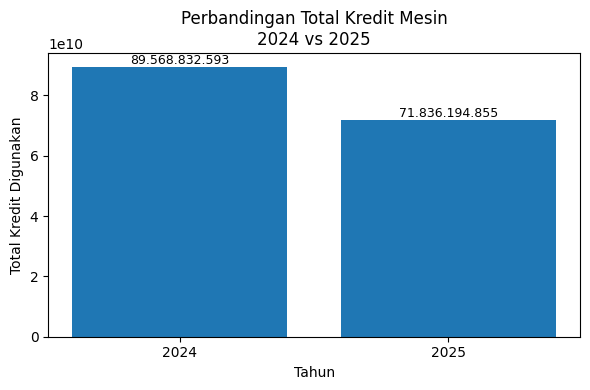

In [74]:
#jadikan format rupiah
def format_id(x):
    return f"{int(x):,}".replace(",", ".")
#pastikan datetime
df['Tahun'] = df['Tanggal'].dt.year
df['Bulan'] = df['Tanggal'].dt.month

yearly_compare = (
    df[df['Tahun'].isin([2024, 2025])]
    .groupby('Tahun')['Kredit yg Digunakan']
    .sum()
)

fig, ax = plt.subplots(figsize=(6,4))

bars = ax.bar(
    yearly_compare.index.astype(str),
    yearly_compare.values
)

ax.set_title("Perbandingan Total Kredit Mesin\n2024 vs 2025")
ax.set_ylabel("Total Kredit Digunakan")
ax.set_xlabel("Tahun")

# Tambahkan label angka di atas bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        format_id(height),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


LINE CHART – Tren Bulanan

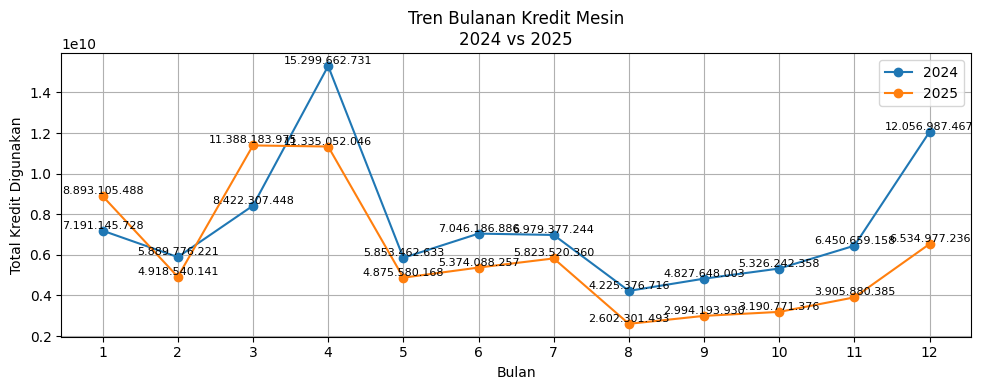

In [75]:
monthly_trend = (
    df[df['Tahun'].isin([2024, 2025])]
    .groupby(['Tahun', 'Bulan'])['Kredit yg Digunakan']
    .sum()
    .reset_index()
)

plt.figure(figsize=(10,4))

for tahun in [2024, 2025]:
    data = monthly_trend[monthly_trend['Tahun'] == tahun]
    
    plt.plot(
        data['Bulan'],
        data['Kredit yg Digunakan'],
        marker='o',
        label=str(tahun)
    )
    
    # Tambahkan label di titik
    for _, row in data.iterrows():
        plt.text(
            row['Bulan'],
            row['Kredit yg Digunakan'],
            format_id(row['Kredit yg Digunakan']),
            fontsize=8,
            ha='center',
            va='bottom'
        )

plt.title("Tren Bulanan Kredit Mesin\n2024 vs 2025")
plt.xlabel("Bulan")
plt.ylabel("Total Kredit Digunakan")
plt.xticks(range(1,13))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Cek barplot df_dashboard (toko aktif)

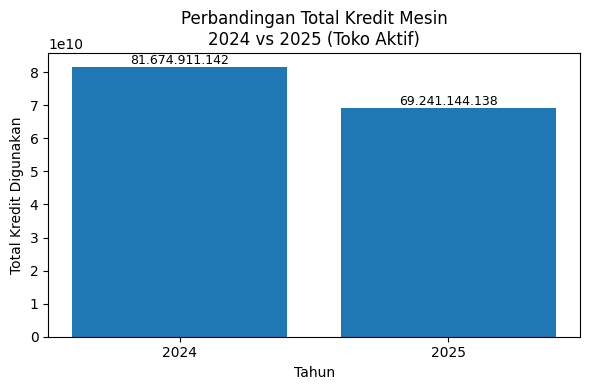

In [89]:
#jadikan format rupiah
def format_id(x):
    return f"{int(x):,}".replace(",", ".")
#pastikan datetime
df_dashboard['Tahun'] = df_dashboard['Tanggal'].dt.year
df_dashboard['Bulan'] = df_dashboard['Tanggal'].dt.month

yearly_compare = (
    df_dashboard[df_dashboard['Tahun'].isin([2024, 2025])]
    .groupby('Tahun')['Kredit yg Digunakan']
    .sum()
)

fig, ax = plt.subplots(figsize=(6,4))

bars = ax.bar(
    yearly_compare.index.astype(str),
    yearly_compare.values
)

ax.set_title("Perbandingan Total Kredit Mesin\n2024 vs 2025 (Toko Aktif)")
ax.set_ylabel("Total Kredit Digunakan")
ax.set_xlabel("Tahun")

# Tambahkan label angka di atas bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        format_id(height),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


LINE CHART – Tren Bulanan (Toko Aktif)

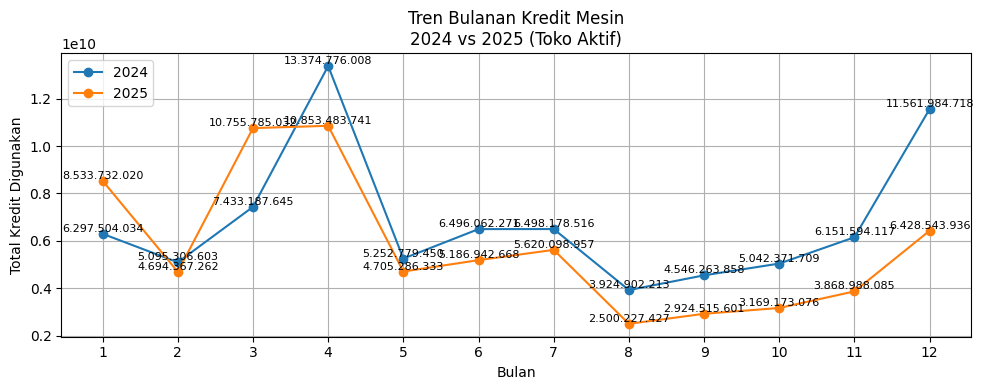

In [90]:
monthly_trend = (
    df_dashboard[df_dashboard['Tahun'].isin([2024, 2025])]
    .groupby(['Tahun', 'Bulan'])['Kredit yg Digunakan']
    .sum()
    .reset_index()
)

plt.figure(figsize=(10,4))

for tahun in [2024, 2025]:
    data = monthly_trend[monthly_trend['Tahun'] == tahun]
    
    plt.plot(
        data['Bulan'],
        data['Kredit yg Digunakan'],
        marker='o',
        label=str(tahun)
    )
    
    # Tambahkan label di titik
    for _, row in data.iterrows():
        plt.text(
            row['Bulan'],
            row['Kredit yg Digunakan'],
            format_id(row['Kredit yg Digunakan']),
            fontsize=8,
            ha='center',
            va='bottom'
        )

plt.title("Tren Bulanan Kredit Mesin\n2024 vs 2025 (Toko Aktif)")
plt.xlabel("Bulan")
plt.ylabel("Total Kredit Digunakan")
plt.xticks(range(1,13))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Export df_dashboard

Cek kolom df_dashboard

In [91]:
df_dashboard.head()

,Center,Kode Game,Game Title,Keterangan,Kategori Game,Jumlah Diaktifkan,Kredit yg Digunakan,Bonus yg Digunakan,Main Gratis/Koin Masuk,QRIS,...,Asal_Folder,Nama_File_Asal,Bulan_num,Tanggal,GT_RAW_NORM,GT_FINAL,Center_NORM,Center_RAW,IN_SCOPE_TOKO,Center_MAPPED
236,Kebayoran Lama (R-102) IFS,07/03/2014/082,KARAOKE BOX,KARAOKE BOX #4,Karaoke,5,73500.0,0.0,0,0,...,data-mesin,Laporan_Agustus_2024.xlsx,8,2024-08-01,KARAOKE BOX,KARAOKE BOX,KEBAYORAN LAMA (R-102) IFS,Kebayoran Lama (R-102) IFS,True,R102 Kebayoran Lama
239,Kebayoran Lama (R-102) IFS,07/03/2014/100,BIG BIKE,Big Bike,Kiddy Ride,68,266230.0,19370.0,0,0,...,data-mesin,Laporan_Agustus_2024.xlsx,8,2024-08-01,BIG BIKE,BIG BIKE,KEBAYORAN LAMA (R-102) IFS,Kebayoran Lama (R-102) IFS,True,R102 Kebayoran Lama
240,Kebayoran Lama (R-102) IFS,07/03/2014/098,BUBU CAR ( FIRE FIGHTER),Bubu car ( Fire Fighter),Kiddy Ride,1,4200.0,0.0,0,0,...,data-mesin,Laporan_Agustus_2024.xlsx,8,2024-08-01,BUBU CAR ( FIRE FIGHTER),BU BU CAR,KEBAYORAN LAMA (R-102) IFS,Kebayoran Lama (R-102) IFS,True,R102 Kebayoran Lama
241,Kebayoran Lama (R-102) IFS,07/03/2014/086,CLASIK WAGON,Clasik wagon,Kiddy Ride,74,292200.0,18600.0,0,0,...,data-mesin,Laporan_Agustus_2024.xlsx,8,2024-08-01,CLASIK WAGON,CLASIK WAGON,KEBAYORAN LAMA (R-102) IFS,Kebayoran Lama (R-102) IFS,True,R102 Kebayoran Lama
243,Kebayoran Lama (R-102) IFS,05/02/2016/147,GOGO PONY,GOGO PONY #1,Kiddy Ride,177,706807.0,36593.0,0,0,...,data-mesin,Laporan_Agustus_2024.xlsx,8,2024-08-01,GOGO PONY,GOGO P0NY,KEBAYORAN LAMA (R-102) IFS,Kebayoran Lama (R-102) IFS,True,R102 Kebayoran Lama


Ekspor df_dashboard

In [94]:
cols_dashboard = [
    'Tanggal',
    'Center_MAPPED',
    'GT_FINAL',
    'Kategori Game',
    'Keterangan',
    'Kredit yg Digunakan',
    'Jumlah Diaktifkan'
]

df_dashboard[cols_dashboard].to_excel(
    "dashboard_in_scope_compact.xlsx",
    index=False
)


In [95]:
gt_list = sorted(df_dashboard['GT_FINAL'].unique())

suspect_pairs = []

for gt in gt_list:
    matches = get_close_matches(gt, gt_list, n=3, cutoff=0.85)
    for m in matches:
        if gt != m:
            suspect_pairs.append((gt, m))

suspect_pairs[:20]


[('BASE BALL HERO', 'BASEBALL HERO'),
 ('BASEBALL HERO', 'BASE BALL HERO'),
 ('BATRAI CAR 3', 'BATRAI CAR 4'),
 ('BATRAI CAR 4', 'BATRAI CAR 3'),
 ('BATTLE GEAR', 'BATTLE GEAR 2'),
 ('BATTLE GEAR 2', 'BATTLE GEAR'),
 ('BEAR RESCUE', 'BEER RESCUE'),
 ('BEER RESCUE', 'BEAR RESCUE'),
 ('BIG CANNON', 'BIG CANON'),
 ('BIG CANON', 'BIG CANNON'),
 ('CAMIC TRAIN', 'COMIC TRAIN'),
 ('CAROUSEL', 'CARROSEL'),
 ('CARROSEL', 'CAROUSEL'),
 ('CARTON PLANE', 'CARTOON PLANE'),
 ('CARTOON PLANE', 'CARTON PLANE'),
 ('CASTEL TRAIN', 'CASTLE TRAIN'),
 ('CASTLE TRAIN', 'CASTEL TRAIN'),
 ('CATCH DA BEAR', 'CATCH DA BEAR B'),
 ('CATCH DA BEAR', 'CATCH DA BEAR A'),
 ('CATCH DA BEAR A', 'CATCH DA BEAR B')]